# Visualización de conjuntos de datos de Stanford y Santa Maria
Roberto Araya Day

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import random
import os
from PIL import Image
from scipy.ndimage import zoom
import skimage

/home/roberto/anaconda3/envs/lung_radiomics/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def show_slice_window(slice, level, window):

    """
    Permite ajustar nivel y ancho de ventana para mejorar contraste de la imagen.
    input: imagen np.array 2D.
    output: imagen np.array 2D ajustada.
   """
    max = level + window/2
    min = level - window/2
    return slice.clip(min,max)


def map_fun(image, label) :    
    
    #TODO 
    crop_size = 256    
    image = (image - min_val)/ val_range
    image = tf.image.grayscale_to_rgb(image)
    size = int(crop_size * 1.15)
    image = tf.image.resize_with_pad(image, size, size)
    image = tf.image.random_crop(image, (crop_size, crop_size,3))
    image = tf.image.random_flip_left_right(image)
    label =  tf.one_hot(label, 2)
    return image, label


def extract_roi(image, mask, margin, min_val):
    # Convert mask to boolean tensor
    mask = tf.cast(mask, dtype=tf.bool)

    # Find indices where mask equals 1
    indices = tf.where(mask)
    
    #image = tf.where(mask, image, min_val)

    # Get the minimum and maximum indices along each axis
    min_row = tf.reduce_min(indices[:, 0])
    min_col = tf.reduce_min(indices[:, 1])
    max_row = tf.reduce_max(indices[:, 0])
    max_col = tf.reduce_max(indices[:, 1])

    # Extract the bounding box from the image
    bounding_box = image[min_row-margin:max_row + 1+margin, min_col-margin:max_col + 1+margin]

    return bounding_box

## Visualizar ejemplos multimodales

In [13]:
max_val = 1000
min_val = -1000
val_range = max_val - min_val
padding = 4
size = 256

def visualize_n_samples(n_patients, n_samples, body_ds, body_info, torax_ds, torax_info, pet_ds, pet_info, show_slice_fn=True, padding=1):
    # Obtener las claves de los conjuntos de datos para cada modalidad
    body_keys, torax_keys, pet_keys = list(body_info.splits.keys()), list(torax_info.splits.keys()), list(pet_info.splits.keys())

    # Inicializar contadores
    patients_counter = 0

    # Iterar sobre las claves comunes a los tres conjuntos de datos
    for key in set(body_keys) & set(torax_keys) & set(pet_keys):
        patients_counter += 1
        # Obtener datos para cada modalidad del paciente actual
        body_data, torax_data, pet_data = body_ds[key], torax_ds[key], pet_ds[key]
        print("patient:", key)

        # Inicializar el contador de muestras
        samples_counter = 0

        # Iterar sobre las muestras de cada modalidad
        for body_sample, torax_sample, pet_sample in zip(body_data, torax_data, pet_data):
            samples_counter += 1

            # Crear una figura con subgráficos
            f, axarr = plt.subplots(2, 3, figsize=(10, 7))
            
            # Iterar sobre las modalidades y mostrar las imágenes y máscaras
            modalities = ["Body Exam", "Torax 3D Exam", "Pet Exam"]
            for i, (sample, title) in enumerate(zip([body_sample, torax_sample, pet_sample], modalities)):
                label = sample['label']
                axarr[0, i].set_title(f"{title} - Label {label}")
                cmap = 'gray_r' if sample is pet_sample else 'gray'
                axarr[0, i].imshow(sample['img_exam'], cmap=cmap)
                axarr[0, i].imshow(sample['mask_exam'], cmap='gnuplot', alpha=0.4)

            # Iterar sobre las modalidades y mostrar las imágenes con la máscara de la región de interés (ROI)
            for i, (sample, title) in enumerate(zip([body_sample, torax_sample, pet_sample], modalities)):
                label = sample['label']
                axarr[1, i].set_title(f"{title} ROI Mask")

                #img_exam = tf.where(sample['img_exam'] < min_val, min_val, sample['img_exam'])
                #img_exam = tf.where(sample['img_exam'] > max_val, max_val, sample['img_exam'])
                img_exam = sample['img_exam']
                
                data_roi = extract_roi(img_exam, sample['mask_exam'], margin = padding, min_val=min_val)  
                
                #print('{} {} {}'.format(np.min(data_roi), np.max(data_roi), data_roi.shape))
                data_roi = tf.expand_dims(data_roi, -1)
                imm = tf.image.resize(data_roi, (size, size))
        
                #if (sample is body_sample or sample is torax_sample) and show_slice_fn: imm = show_slice_window(imm, 70, 140)
                cmap = 'gray_r' if sample is pet_sample else 'gray'
                axarr[1, i].imshow(imm, cmap=cmap)
            
            # Mostrar la figura con subgráficos
            plt.show()

            # Romper el bucle si se alcanza el número deseado de muestras
            if samples_counter >= n_samples:
                break
        
        # Romper el bucle si se alcanza el número deseado de pacientes
        if patients_counter >= n_patients:
            break

patient: sm_001


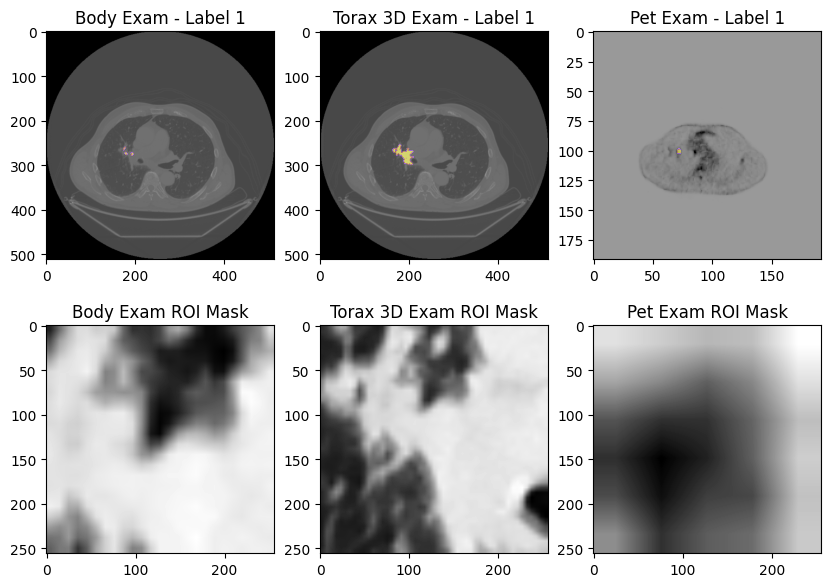

patient: sm_011


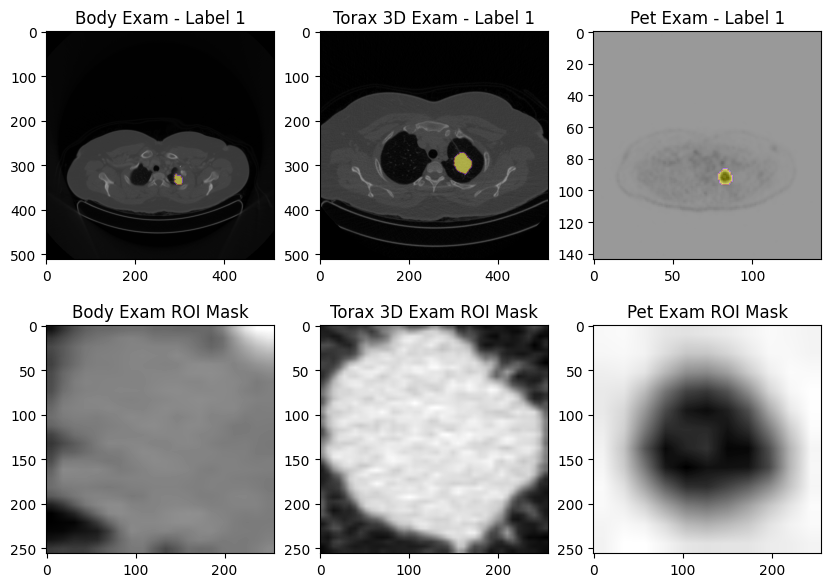

patient: sm_032


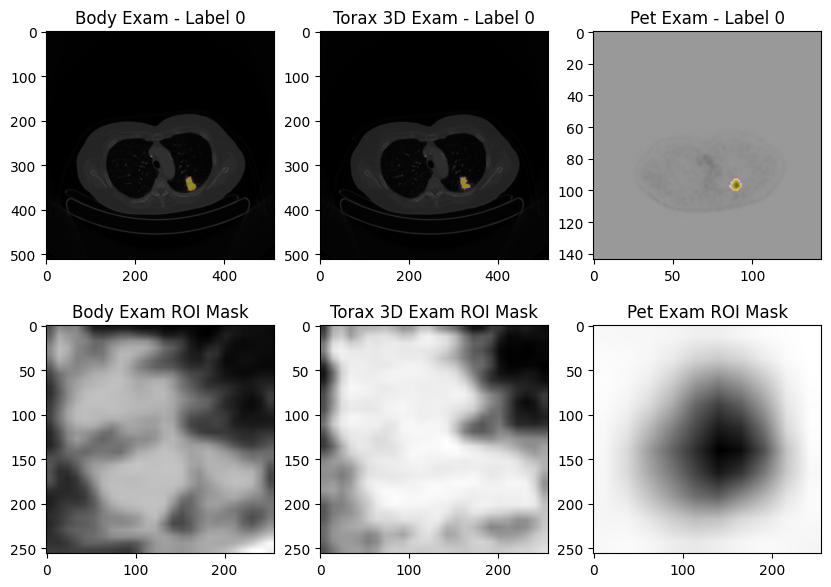

patient: sm_014


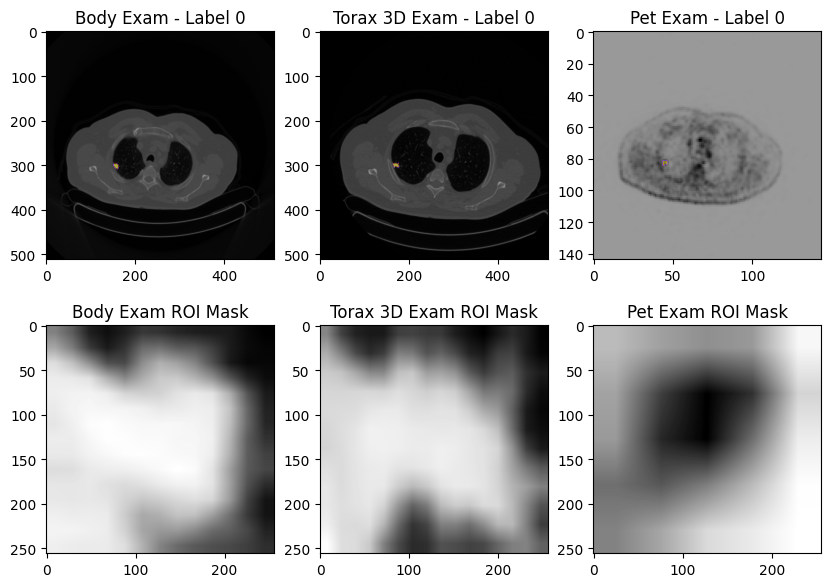

patient: sm_003


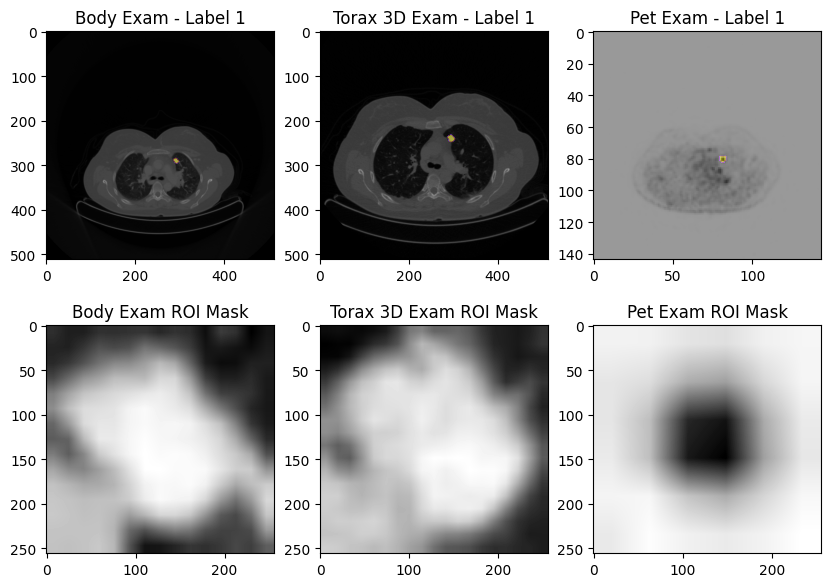

patient: sm_028


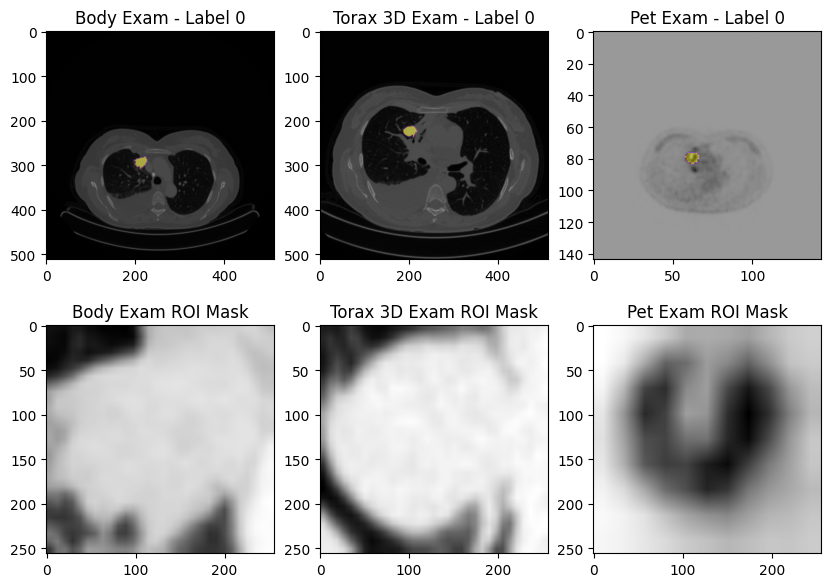

patient: sm_015


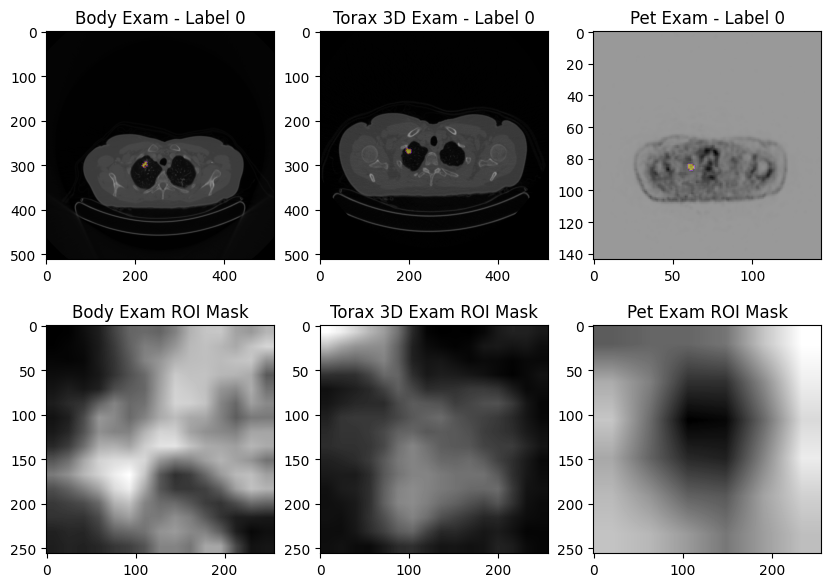

patient: sm_034


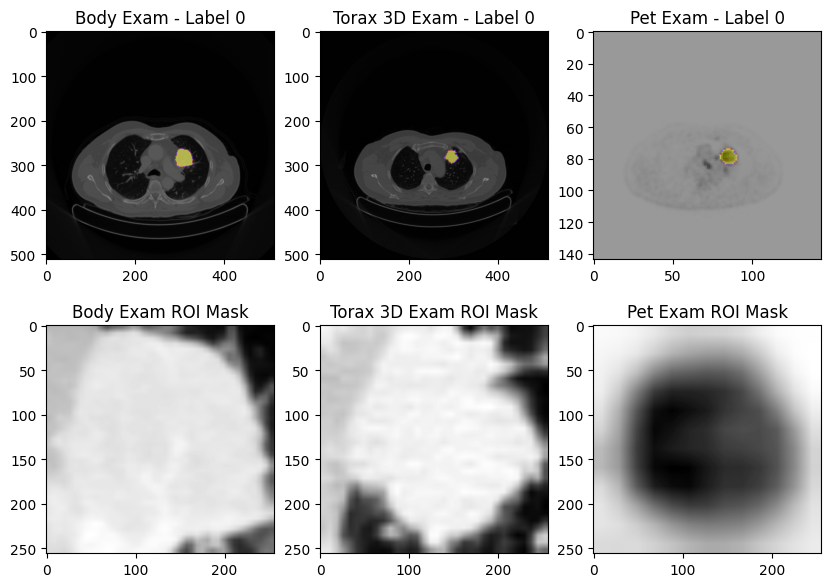

patient: sm_020


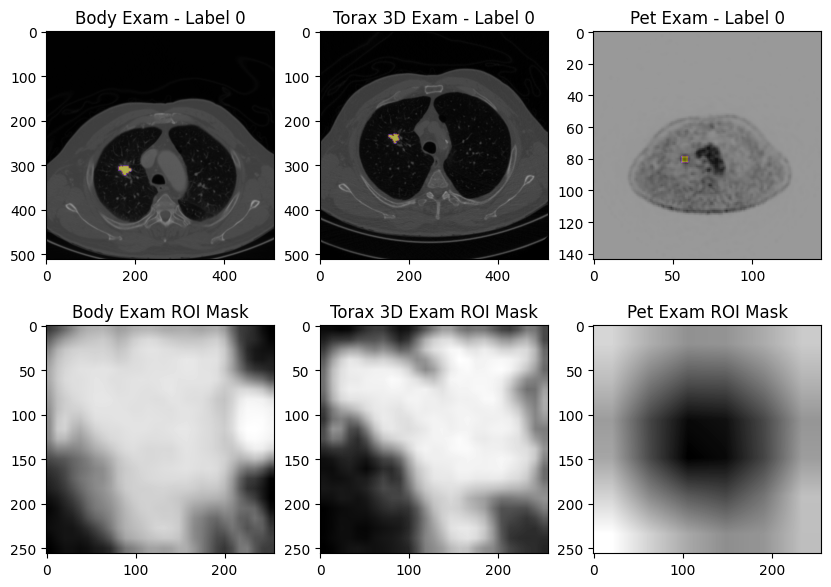

patient: sm_025


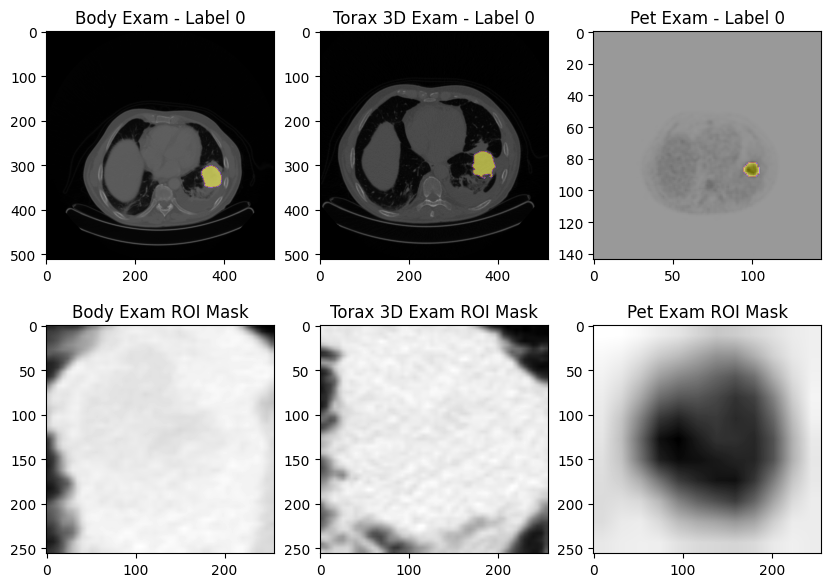

In [14]:
# se cargan los conjuntos de datos de santa maria
santamaria_body_dataset, santamaria_body_info = tfds.load('santa_maria_dataset/body', with_info=True)
santamaria_torax_dataset, santamaria_torax_info = tfds.load('santa_maria_dataset/torax3d', with_info=True)
santamaria_pet_dataset, santamaria_pet_info = tfds.load('santa_maria_dataset/pet', with_info=True)

# cantidad de pacientes a mostrar, cantidad de ejemplos y función de extraccion de ROI
n_patients = 10
n_samples = 1

visualize_n_samples(n_patients, n_samples, 
                    santamaria_body_dataset, santamaria_body_info, santamaria_torax_dataset, 
                     santamaria_torax_info, santamaria_pet_dataset, santamaria_pet_info)

patient: R01-025


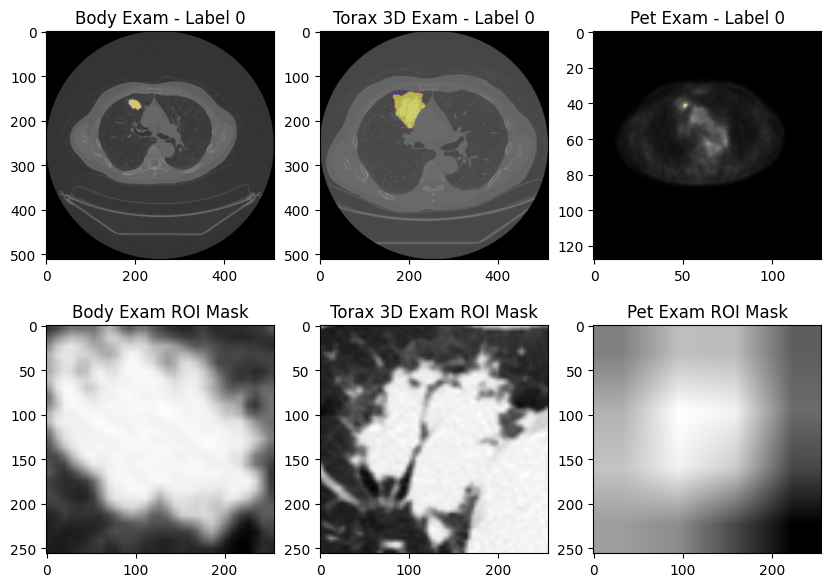

patient: AMC-017


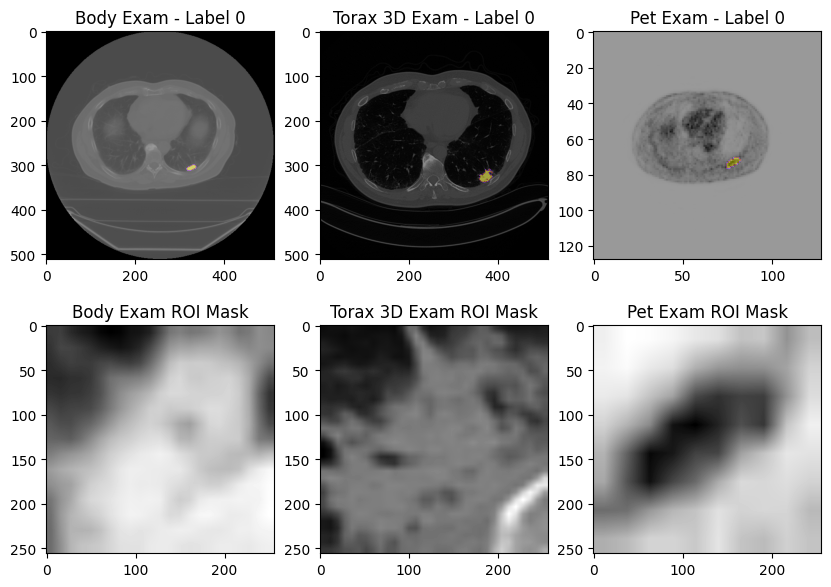

patient: AMC-048


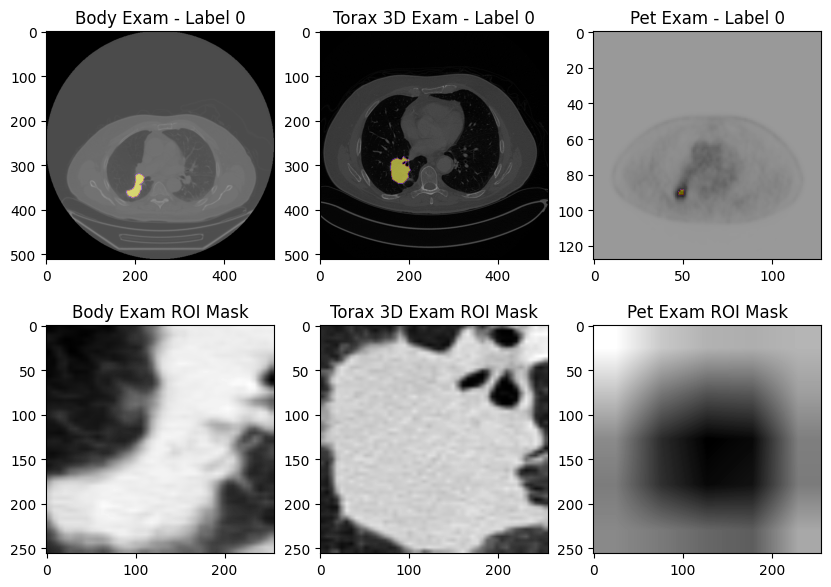

patient: R01-092


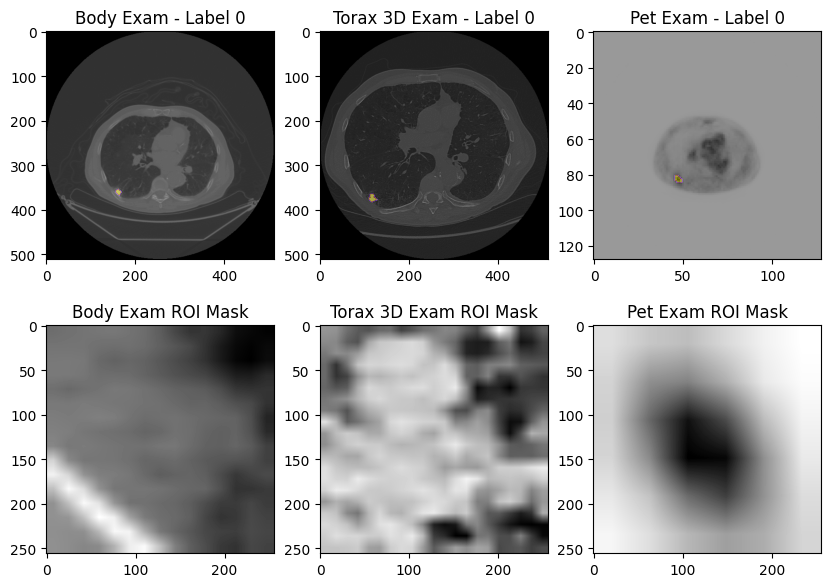

patient: R01-045


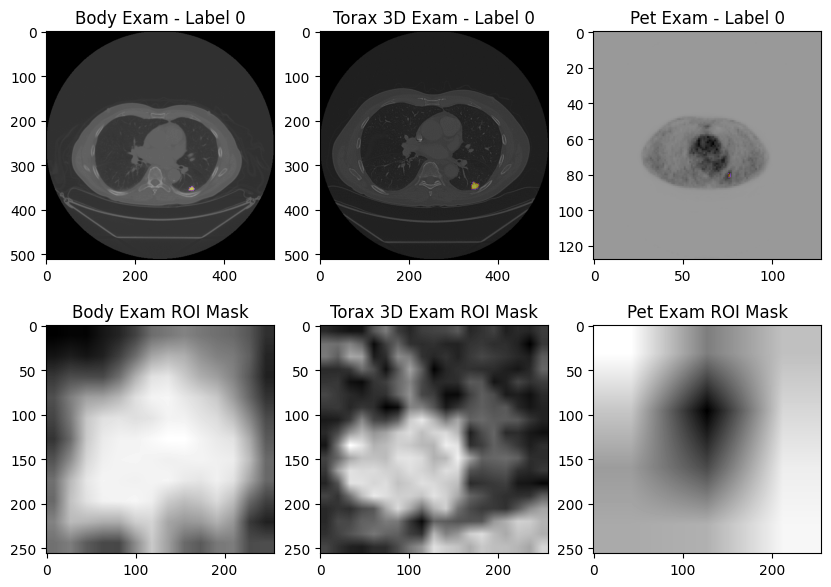

patient: R01-071


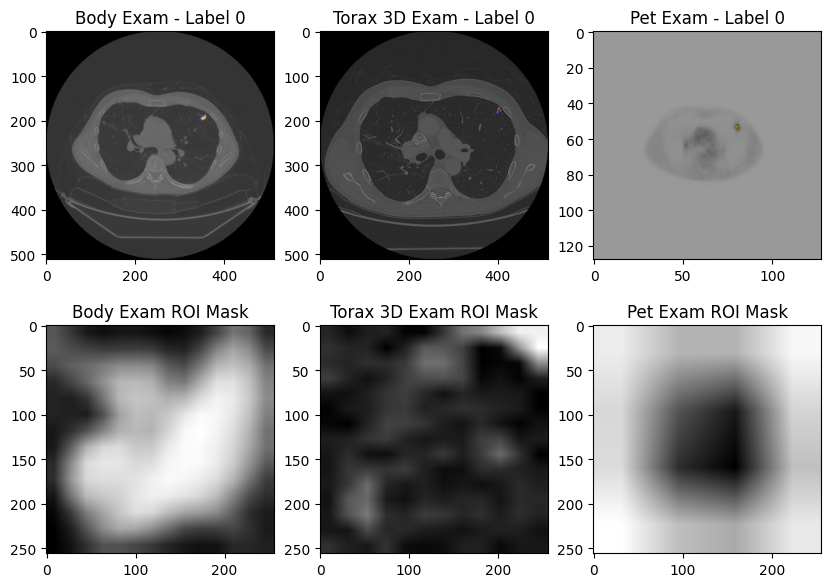

patient: R01-128


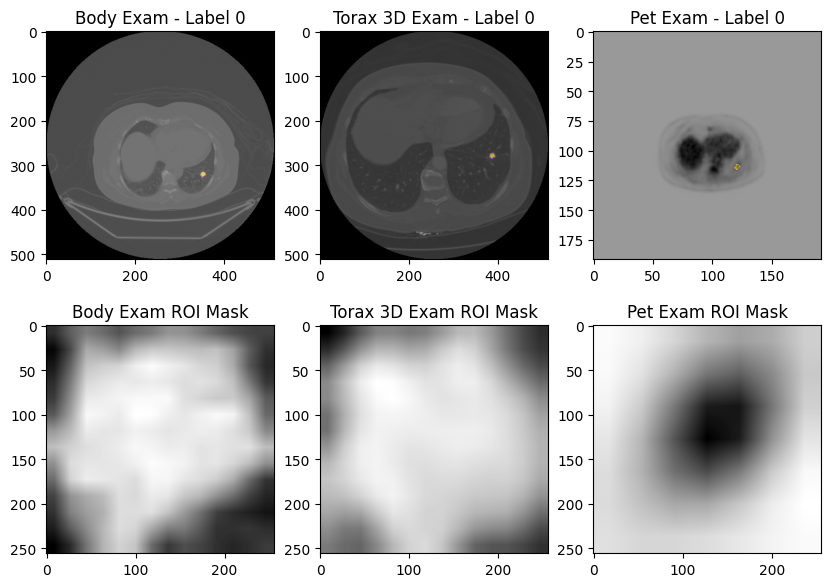

patient: R01-052


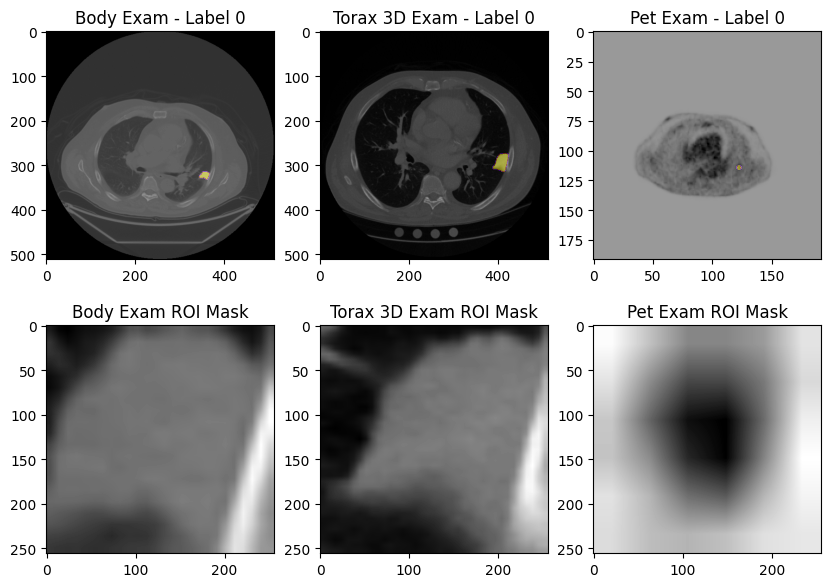

patient: R01-057


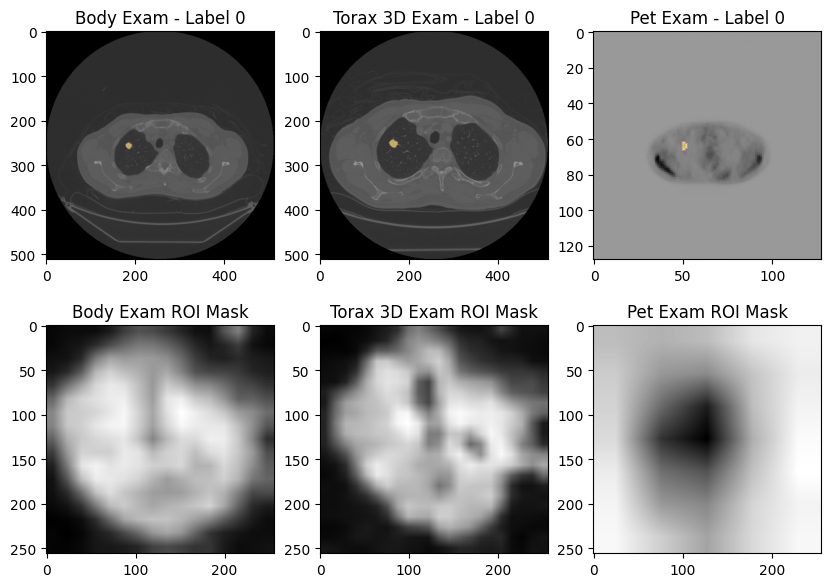

patient: R01-146


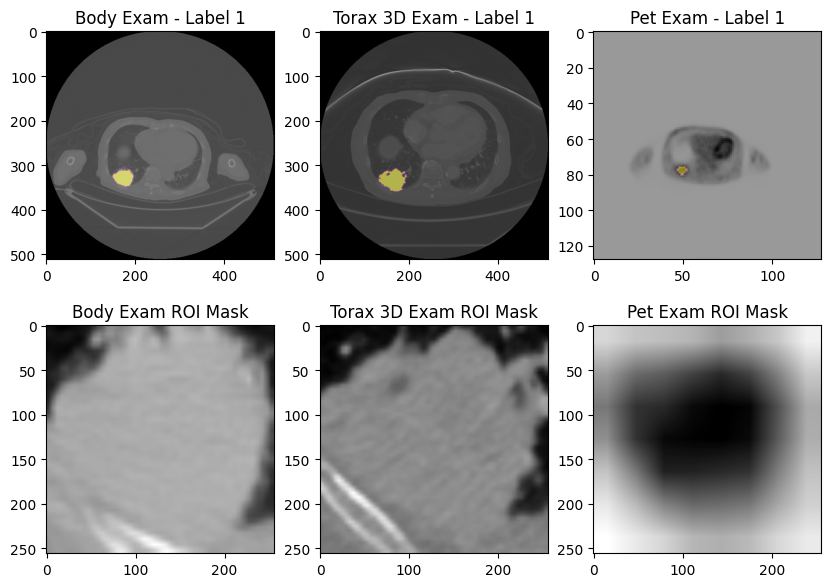

In [15]:
# se cargan los conjuntos de datos de santa maria
stanford_body_dataset, stanford_body_info = tfds.load('stanford_dataset/ct', with_info=True)
stanford_torax_dataset, stanford_torax_info = tfds.load('stanford_dataset/chest_ct', with_info=True)
stanford_pet_dataset, stanford_pet_info = tfds.load('stanford_dataset/pet', with_info=True)

# cantidad de pacientes a mostrar, cantidad de ejemplos y función de extraccion de ROI
n_patients = 10
n_samples = 1

visualize_n_samples(n_patients, n_samples, 
                    stanford_body_dataset, stanford_body_info, stanford_torax_dataset, 
                    stanford_torax_info, stanford_pet_dataset, stanford_pet_info)
